# Recommend RNA sequences 

This notebook shows the online recommendation of RBS sequences with the goal of achieving a high protein expression level.

There are several parts of the implementation. 

- Reading the dataset
- Embedding
    - One-hot embedding
    - K-mer 
    - PMW
    - Kernels
    - Unsupervised 
- Create reward environment
- Apply bandits algorithms
    - GPUCB

In [2]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB
from codes.evaluations import evaluate, plot_eva
from codes.regression import Regression

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import RBF

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

### Description 

This notebook runs experiments for paper [High-throughput cellular RNA device engineering](https://www.nature.com/articles/nmeth.3486#Sec8)

There are two worksheets in there: panel (a) and panel (b) – we will use the B one. There are 37,301 data points there out of 174,720 (4^8 + 4^7 + 4^6 + 4^5 + 4^4 + 4^3) possible combinations – this is because they have gated the bad results out of the analysis – basically they have set a threshold of 0.5 for the ratio of the two parameters you have in the dataset and they have removed all that didn’t fit in that threshold. Now, the analysed DNA sequence is this (randomized part is in bold, it can be from 3 to 8 bases, N is any base from ATGC set):

 

Group One: GCTGTCACCGG$\textbf{NNNNNNNN}$CCGGTCTGATGAGTCC$\underline{ATACCAGCATCGTCTTGATGCCCTTGG\textbf{(C/A)}AG}$GGACGAAACAGC

 

So the 8N is the region that can be between 3 and 8 base pair long with any letter from the (ATGC) and there is one extra region of randomness at the end, which is shown as C/A, which means it can be either C or A only.

 

But. There is also a second version where the 8N fragment and the underlined fragments are swapped:

 
Group Two: 
GCTGTCACCGGA$\underline{ATACCAGCATCGTCTTGATGCCCTTGG\textbf{(C/A)}AG}$TCCGGTCTGATGAGTCC$\textbf{NNNNNNNN}$GGACGAAACAGC

 

This gives you (4^8 + 4^7 + 4^6 + 4^5 + 4^4 + 4^3) * 2 * 2 =  349440 possible combinations, so we end up with 37031 variants tested (so with labels) out of that.

 

The label is the ratio between second parameter and the first one (they are two fluorescence values) (fourth column).

## Reading the Dataset

In [4]:
Path = '../data/41592_2015_BFnmeth3486_MOESM583_ESM-1.xlsx'

df = pd.read_excel(Path, sheet_name='Panel (b)')
df.head()

,Sequence,mu((1-)+(2-)),mu((1+)+(2+)),Ratio
0,GCTGTCACCGGAAAAAAAGTCCGGTCTGATGAGTCCATACCAGCAT...,0.356746,0.757085,2.122196
1,GCTGTCACCGGAAAAAACGTCCGGTCTGATGAGTCCATACCAGCAT...,0.301623,0.583974,1.936106
2,GCTGTCACCGGAAAAAAGGGTCCGGTCTGATGAGTCCATACCAGCA...,0.306372,0.574791,1.876121
3,GCTGTCACCGGAAAAAAGGGTCCGGTCTGATGAGTCCATACCAGCA...,0.459940,0.435896,0.947724
4,GCTGTCACCGGAAAAAAGGTCCGGTCTGATGAGTCCATACCAGCAT...,0.283471,0.573680,2.023770


For now, we only use the data for Group One 

Group One: GCTGTCACCGG$\textbf{NNNNNNNN}$CCGGTCTGATGAGTCC$\underline{ATACCAGCATCGTCTTGATGCCCTTGG\textbf{(C/A)}AG}$GGACGAAACAGC

In [4]:
#df['invariant'] = df['Sequence'].str[:11] + df['Sequence'].str[20: 63] + df['Sequence'].str[64:]
#data = df.loc[df['invariant'] == 'GCTGTCACCGGCCGGTCTGATGAGTCCATACCAGCATCGTCTTGATGCCCTTGGAGGGACGAAACAGC']
#print('Group One has ' + str(data.shape[0]) + ' data points')

Group One has 5926 data points


In [10]:
df['invariant'] = df['Sequence'].str[:11] + df['Sequence'].str[-58: 63] + df['Sequence'].str[64:]
data = df.loc[df['invariant'] == 'GCTGTCACCGGCCGGTCTGATGAGTCCATACCAGCATCGTCTTGATGCCCTTGGAGGGACGAAACAGC']
print('Group One has ' + str(data.shape[0]) + ' data points')

Group One has 7128 data points


In [11]:
data['design_seq'] = data['Sequence'].str[11:-58] + data['Sequence'].str[63]
print('Group One has ' + str(len(data['Sequence'].unique())) + ' unique design sequences')

Group One has 7128 unique design sequences


/home/mengyan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [12]:
data.head()

,Sequence,mu((1-)+(2-)),mu((1+)+(2+)),Ratio,invariant,design_seq
0,GCTGTCACCGGAAAAAAAGTCCGGTCTGATGAGTCCATACCAGCAT...,0.356746,0.757085,2.122196,GCTGTCACCGGCCGGTCTGATGAGTCCATACCAGCATCGTCTTGAT...,AAAAAAAGTA
1,GCTGTCACCGGAAAAAACGTCCGGTCTGATGAGTCCATACCAGCAT...,0.301623,0.583974,1.936106,GCTGTCACCGGCCGGTCTGATGAGTCCATACCAGCATCGTCTTGAT...,AAAAAACGTA
4,GCTGTCACCGGAAAAAAGGTCCGGTCTGATGAGTCCATACCAGCAT...,0.283471,0.573680,2.023770,GCTGTCACCGGCCGGTCTGATGAGTCCATACCAGCATCGTCTTGAT...,AAAAAAGGTA
5,GCTGTCACCGGAAAAAAGTCCGGTCTGATGAGTCCATACCAGCATC...,0.229306,0.655003,2.856458,GCTGTCACCGGCCGGTCTGATGAGTCCATACCAGCATCGTCTTGAT...,AAAAAAGTA
9,GCTGTCACCGGAAAAAATGTCCGGTCTGATGAGTCCATACCAGCAT...,0.356760,0.784430,2.198761,GCTGTCACCGGCCGGTCTGATGAGTCCATACCAGCATCGTCTTGAT...,AAAAAATGTA


In [13]:
data = data[['design_seq', 'Ratio']].to_numpy()
data.shape

(7128, 2)

## Regression

Model:  GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)
Train score:  0.7008289107784891
Test score:  -0.09016962995305966


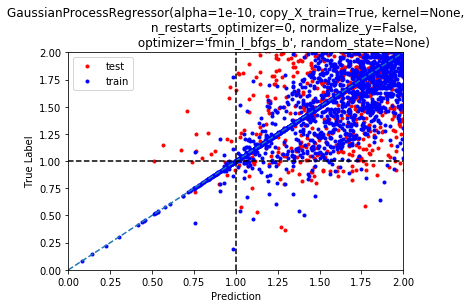

In [16]:
reg = Regression(GaussianProcessRegressor(), data, embedding_method = 'kmer')
reg.train()
reg.evaluate()

## Embedding & Create Rewards Environment

In [16]:
my_env = Rewards_env(data, 'kmer')

In [17]:
my_env.embedded.shape

(5926, 64)

Maximum label: 18.17668257214544


/home/mengyan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


(array([0.00688428, 0.00413057, 0.01789913, 0.02753712, 0.19413669,
        0.39928822, 0.35522883, 0.38965023, 0.59480176, 0.79857644,
        0.86466553, 0.66502142, 0.40341879, 0.26160263, 0.16522271,
        0.09500306, 0.0688428 , 0.04956681, 0.02891397, 0.03029083,
        0.0123917 , 0.01652227, 0.00550742, 0.00963799, 0.00963799,
        0.00826114, 0.00688428, 0.00137686, 0.        , 0.00550742,
        0.00137686, 0.00275371, 0.00275371, 0.00137686, 0.        ,
        0.        , 0.00275371, 0.        , 0.00275371, 0.00137686,
        0.        , 0.00137686, 0.00137686, 0.        , 0.00137686,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00137686, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00137686, 0.        , 0.        ,
        0.00137686, 0.        , 0.        , 0.00

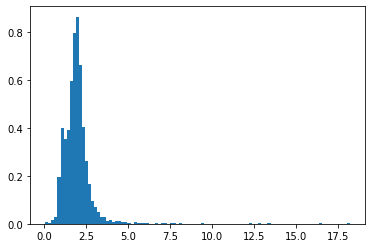

In [18]:
print('Maximum label: ' + str(max(list(my_env.labels_dict.values()))))
plt.hist(list(my_env.labels_dict.values()), bins = 100, normed= True)

## Recommendations with GPUCB

In [19]:
num_rounds = 1000
num_exper = 1
init_per = 0.05

sds = []
rs = []

IntProgress(value=0, description='Running', max=1)

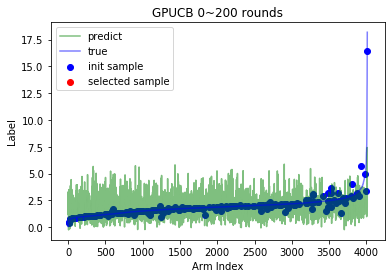

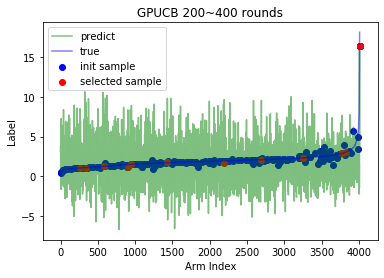

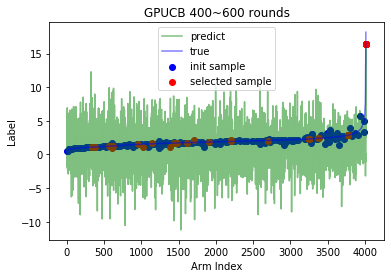

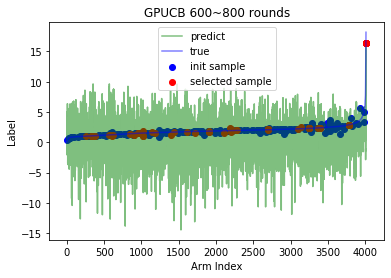

In [20]:
warnings.filterwarnings(action='ignore')

p = IntProgress(max = num_exper)
p.description = 'Running'
display(p)

for i in range(num_exper):
    p.value += 1
    agent = GPUCB(my_env, num_rounds, init_per)
    agent.play(plot_flag = True, plot_per = 200)
    sds.append(agent.suboptimalDraws)
    rs.append(agent.cumulativeRegrets)

In [21]:
results = evaluate(sds, rs)

No handles with labels found to put in legend.


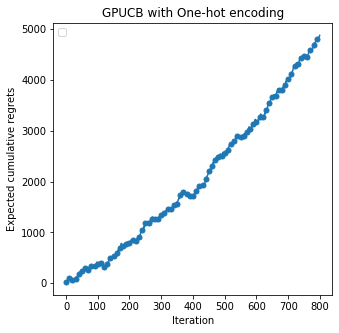

In [22]:
plot_eva(results, 'r')

### Test for spectrum features

In [18]:
from sklearn.feature_extraction.text import CountVectorizer


def phi(X, Y, l):
    num_X = X.shape[0]
    num_Y = Y.shape[0]

    sentences = []

    for i in range(num_X):
        sequence= X[i]
        words = [sequence[j:j+l] for j in range(len(sequence) - l + 1)]
        sentence = ' '.join(words)
        sentences.append(sentence)

    for i in range(num_Y):
        sequence= Y[i]
        words = [sequence[j:j+l] for j in range(len(sequence) - l + 1)]
        sentence = ' '.join(words)
        sentences.append(sentence)

    print(sentences)
    cv = CountVectorizer()
    embedded = cv.fit_transform(sentences).toarray()

    return embedded[: num_X, :], embedded[-num_Y: , :]

In [22]:
import numpy as np
X = np.array(['AGCTAA', 'AGCTGC', 'AAGTAC'])

In [23]:
Y = np.array(['AGCAAA'])

In [24]:
phi(X, Y, 3)

['AGC GCT CTA TAA', 'AGC GCT CTG TGC', 'AAG AGT GTA TAC', 'AGC GCA CAA AAA']


(array([[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]]),
 array([[1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]]))